In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_1.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)

dataFrame["vectorSize"] = dataFrame["vectorSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Vector sizes:", sorted(dataFrame["vectorSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 210
Modes: ['min' 'max']
Vector sizes: [1000000, 5000000, 10000000]
Process counts: [1, 2, 4, 6, 8, 16, 32]


,testType,vectorSize,numProcesses,mode,timeSeconds,resultValue,runIndex,mpiEnv
0,MPI_1,1000000,1,min,0.003276,1.299768,1,SLURM_NTASKS=1;JOBID=12745
1,MPI_1,1000000,1,min,0.003592,0.871026,4,SLURM_NTASKS=1;JOBID=12748
2,MPI_1,1000000,1,min,0.003275,0.255026,2,SLURM_NTASKS=1;JOBID=12746
3,MPI_1,1000000,1,min,0.003691,0.691431,3,SLURM_NTASKS=1;JOBID=12747
4,MPI_1,1000000,2,min,0.002951,1.996530,3,SLURM_NTASKS=2;JOBID=12752
5,MPI_1,1000000,1,min,0.003550,1.423817,5,SLURM_NTASKS=1;JOBID=12749
6,MPI_1,1000000,2,min,0.003001,1.684027,1,SLURM_NTASKS=2;JOBID=12750
7,MPI_1,1000000,2,min,0.003019,0.356110,4,SLURM_NTASKS=2;JOBID=12753


In [3]:
groupedFrame = dataFrame.groupby(["mode","vectorSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","vectorSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,mode,vectorSize,numProcesses,median,mean,std,count
0,max,1000000,1,0.003412,0.003432,0.000112,5
1,max,1000000,2,0.003019,0.003012,0.000023,5
2,max,1000000,4,0.006134,0.006369,0.000807,5
3,max,1000000,6,0.009811,0.009843,0.001351,5
4,max,1000000,8,0.008183,0.008130,0.000748,5
5,max,1000000,16,0.012978,0.013861,0.002043,5
6,max,1000000,32,0.116651,0.117320,0.002395,5
7,max,5000000,1,0.018814,0.018830,0.000160,5
8,max,5000000,2,0.016341,0.016238,0.000191,5
9,max,5000000,4,0.016571,0.016401,0.000319,5


In [4]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, vectorSizeVal), subFrame in groupedDf.groupby(["mode","vectorSize"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,vectorSize,numProcesses,median,mean,std,count,speedup,efficiency
0,max,1000000,1,0.003412,0.003432,0.000112,5,1.000000,1.000000
1,max,1000000,2,0.003019,0.003012,0.000023,5,1.130176,0.565088
2,max,1000000,4,0.006134,0.006369,0.000807,5,0.556244,0.139061
3,max,1000000,6,0.009811,0.009843,0.001351,5,0.347773,0.057962
4,max,1000000,8,0.008183,0.008130,0.000748,5,0.416962,0.052120
5,max,1000000,16,0.012978,0.013861,0.002043,5,0.262906,0.016432
6,max,1000000,32,0.116651,0.117320,0.002395,5,0.029250,0.000914
7,max,5000000,1,0.018814,0.018830,0.000160,5,1.000000,1.000000
8,max,5000000,2,0.016341,0.016238,0.000191,5,1.151337,0.575669
9,max,5000000,4,0.016571,0.016401,0.000319,5,1.135357,0.283839


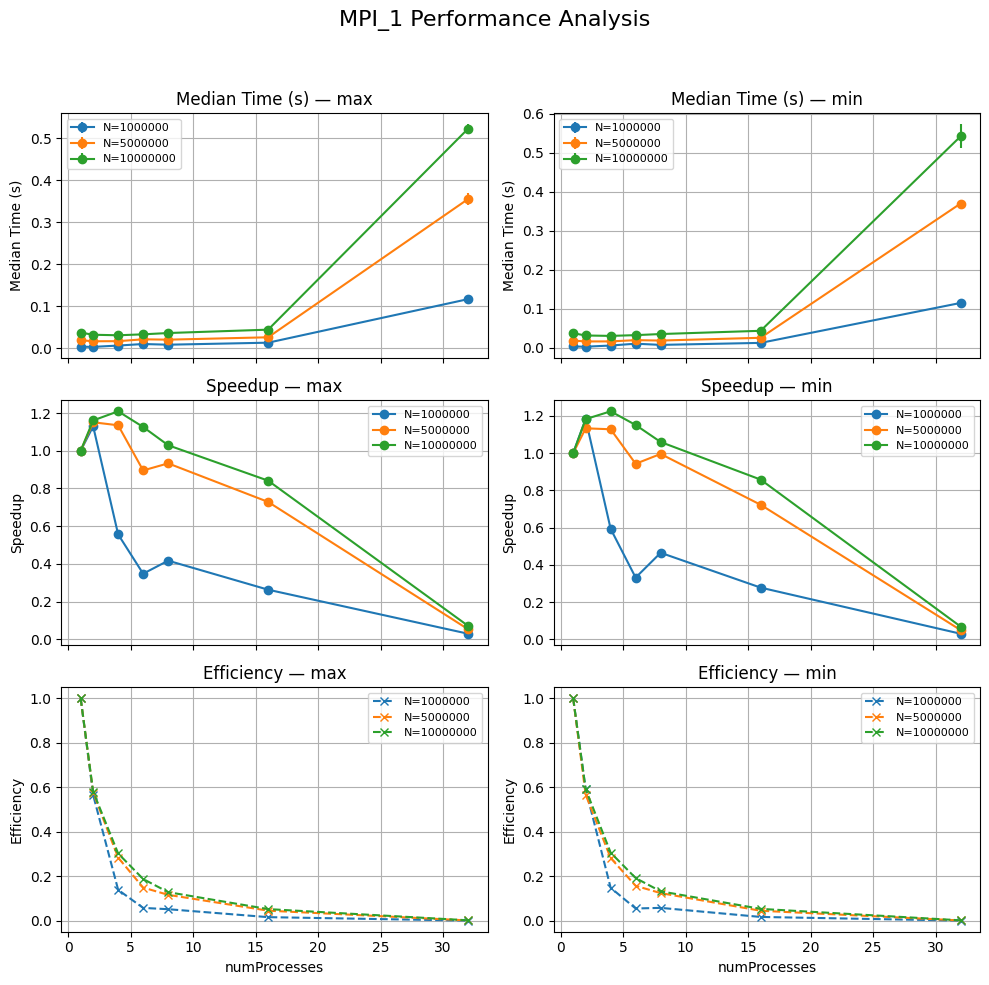

In [5]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

fig, axes = plt.subplots(3, len(modes), figsize=(5 * len(modes), 10), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(3)])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        for vectorSizeVal in sorted(perfFrame["vectorSize"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["vectorSize"]==vectorSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={vectorSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={vectorSizeVal}")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("MPI_1 Performance Analysis", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [6]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numProcesses", columns="vectorSize", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numProcesses", columns="vectorSize", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)

summaryRows = []
for (modeVal, vectorSizeVal), sub in perfFrame.groupby(["mode","vectorSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "vectorSize": vectorSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Process": medianAtOne
    })
summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","vectorSize"])
display(summaryAnalysisFrame)



=== mode: max — median time (s) ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,0.003412,0.018814,0.037005
2,0.003019,0.016341,0.031872
4,0.006134,0.016571,0.030596
6,0.009811,0.021004,0.032855
8,0.008183,0.020158,0.035946
16,0.012978,0.025820,0.043974
32,0.116651,0.354860,0.522210



=== mode: max — speedup ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,1.000000,1.000000,1.000000
2,1.130176,1.151337,1.161050
4,0.556244,1.135357,1.209472
6,0.347773,0.895734,1.126313
8,0.416962,0.933327,1.029461
16,0.262906,0.728660,0.841520
32,0.029250,0.053018,0.070862



=== mode: min — median time (s) ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,0.003550,0.018664,0.037543
2,0.003001,0.016466,0.031739
4,0.005979,0.016541,0.030654
6,0.010689,0.019789,0.032606
8,0.007628,0.018740,0.035417
16,0.012750,0.025809,0.043746
32,0.115166,0.370034,0.542227



=== mode: min — speedup ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,1.000000,1.000000,1.000000
2,1.182939,1.133487,1.182867
4,0.593745,1.128348,1.224734
6,0.332117,0.943150,1.151414
8,0.465391,0.995945,1.060028
16,0.278431,0.723159,0.858204
32,0.030825,0.050439,0.069239


,mode,vectorSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Process
0,max,1000000,2,1.130176,0.565088,0.003412
1,max,5000000,2,1.151337,0.575669,0.018814
2,max,10000000,4,1.209472,0.302368,0.037005
3,min,1000000,2,1.182939,0.591470,0.003550
4,min,5000000,2,1.133487,0.566744,0.018664
5,min,10000000,4,1.224734,0.306184,0.037543
